In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GroupShuffleSplit

# 1. Load the French Motor Third-Party Liability dataset
# Source: OpenML ID 41214 (referenced in Case Study 8)
print("Fetching data from OpenML (this may take a moment)...")
df_raw = fetch_openml(data_id=41214, as_frame=True, parser='pandas').frame

# 2. Actuarial Preprocessing (Ref: SAV Case Study 8, p01_prep.R)
def preprocess_actuarial_data(df):
    dat = df.copy()
    
    # Identify unique policy clusters (Group ID)
    # Essential to prevent data leakage during splitting.
    # Note: observed=True is added to handle categorical grouping correctly.
    features_for_id = [c for c in dat.columns if c not in ["IDpol", "Exposure", "ClaimNb"]]
    dat["group_id"] = dat.groupby(features_for_id, observed=True).ngroup()
    
    # Actuarial transformations and outliers clipping
    # Exposure is capped at 1.0 (standard for annual frequency modeling)
    dat["Exposure"] = dat["Exposure"].clip(upper=1.0)
    
    # Frequency is the target: ClaimNb / Exposure
    dat["Freq"] = (dat["ClaimNb"] / dat["Exposure"]).clip(upper=15)
    
    # Numerical features clipping based on Case Study 8 specs
    dat["VehPower"] = dat["VehPower"].clip(upper=12)
    dat["VehAge"] = dat["VehAge"].clip(upper=20)
    dat["DrivAge"] = dat["DrivAge"].clip(upper=85)
    dat["logDensity"] = np.log(dat["Density"])
    
    # Ensure categorical consistency and brand naming (B1, B2, etc.)
    dat["VehBrand"] = dat["VehBrand"].astype(str).apply(lambda x: x if x.startswith('B') else 'B'+x)
    dat["VehBrand"] = dat["VehBrand"].astype("category")
    dat["PolicyRegion"] = dat["Region"].astype("category")
    dat["VehGas"] = dat["VehGas"].astype("category")
    
    return dat

dat = preprocess_actuarial_data(df_raw)

# 3. Stratified Grouped Split
# We use GroupShuffleSplit to ensure that all observations belonging to the same 
# 'group_id' stay together in either Train or Test set.
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=22)
train_idx, test_idx = next(gss.split(dat, groups=dat["group_id"]))
train, test = dat.iloc[train_idx].copy(), dat.iloc[test_idx].copy()

print(f"Preprocessing complete.")
print(f"Train set size: {len(train)} | Test set size: {len(test)}")

Fetching data from OpenML (this may take a moment)...
Preprocessing complete.
Train set size: 542184 | Test set size: 135829


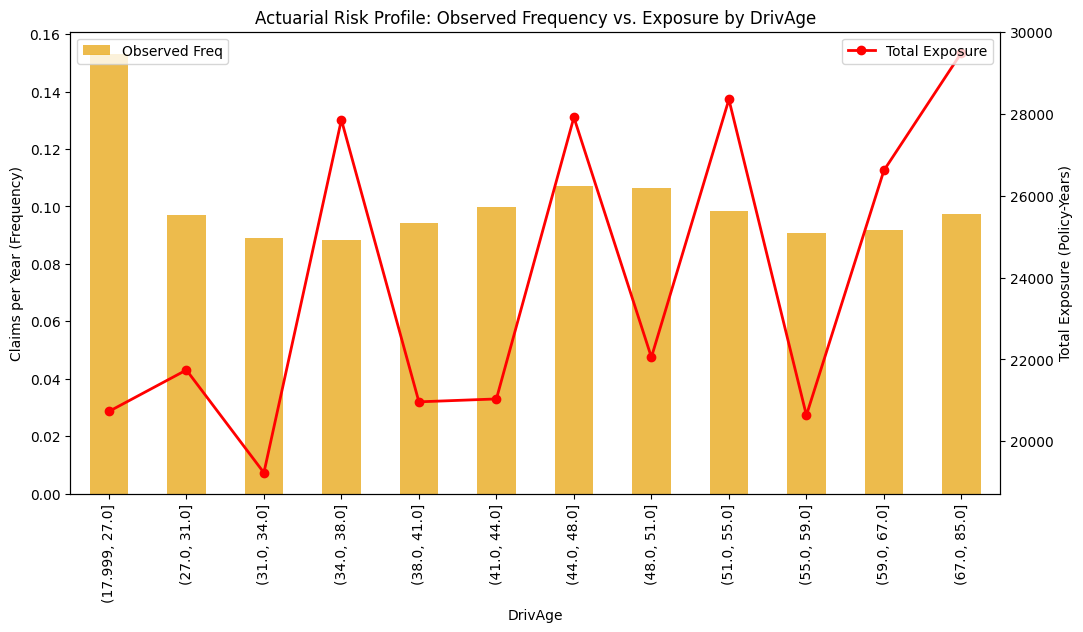

In [2]:
def plot_frequency_profile(df, feature, n_bins=12):
    """
    Plots the observed frequency vs. total exposure for a given feature.
    This demonstrates the risk distribution across different segments.
    """
    df_plot = df.copy()
    
    # Handle numerical features by binning to see trends
    if df_plot[feature].dtype.name != 'category' and df_plot[feature].nunique() > 15:
        df_plot[feature + '_binned'] = pd.qcut(df_plot[feature], q=n_bins, duplicates='drop')
        col_to_plot = feature + '_binned'
    else:
        col_to_plot = feature
        
    # Aggregate data by weighting by Exposure
    summary = df_plot.groupby(col_to_plot, observed=True).agg(
        total_claims=('ClaimNb', 'sum'),
        total_exposure=('Exposure', 'sum')
    )
    summary['observed_frequency'] = summary['total_claims'] / summary['total_exposure']
    
    # Visualization: Dual-axis plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Bar plot for Observed Frequency
    summary['observed_frequency'].plot(kind='bar', ax=ax1, color='#E69F00', alpha=0.7, label='Observed Freq')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Claims per Year (Frequency)')
    ax1.legend(loc='upper left')
    
    # Line plot for Total Exposure (Sample size/confidence)
    ax2 = ax1.twinx()
    summary['total_exposure'].plot(kind='line', ax=ax2, color='red', marker='o', label='Total Exposure', linewidth=2)
    ax2.set_ylabel('Total Exposure (Policy-Years)')
    ax2.legend(loc='upper right')
    ax2.grid(False) # Hide grid for the secondary axis for clarity
    
    plt.title(f'Actuarial Risk Profile: Observed Frequency vs. Exposure by {feature}')
    plt.xticks(rotation=45)
    # plt.show()

# Visualize Driver Age - A primary risk driver in MTPL
plot_frequency_profile(train, 'DrivAge')

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import SplineTransformer, StandardScaler, OneHotEncoder
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_poisson_deviance
import xgboost as xgb

# 1. Define feature groups based on the actuarial study
features_num = ["VehPower", "logDensity"]
features_spline = ["VehAge", "DrivAge"]
features_cat = ["VehBrand", "VehGas", "PolicyRegion"]

# 2. Pipeline for GLM
glm_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), features_num),
        ("spline", SplineTransformer(n_knots=5, degree=3), features_spline),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), features_cat),
    ]
)

glm_pipeline = Pipeline([
    ("preprocessor", glm_preprocessor),
    ("regressor", TweedieRegressor(
        power=1, 
        alpha=0.1, 
        solver='newton-cholesky'
    )) 
])

print("Fitting GLM Poisson...")
glm_pipeline.fit(train[features_num + features_spline + features_cat], 
                 train["Freq"], 
                 regressor__sample_weight=train["Exposure"])

# 3. XGBoost: Preparing data
X_train_xgb = train[features_num + features_spline + features_cat].copy()
X_test_xgb = test[features_num + features_spline + features_cat].copy()

for col in features_cat:
    X_train_xgb[col] = X_train_xgb[col].cat.codes
    X_test_xgb[col] = X_test_xgb[col].cat.codes

dtrain = xgb.DMatrix(X_train_xgb, label=train["Freq"], weight=train["Exposure"])
dtest = xgb.DMatrix(X_test_xgb, label=test["Freq"], weight=test["Exposure"])

# Hyperparameters from Case Study 8
xgb_params = {
    "objective": "count:poisson",
    "learning_rate": 0.2,
    "max_depth": 5,
    "alpha": 3,
    "lambda": 0.5,
    "max_delta_step": 2,
    "subsample": 0.9,
    "seed": 1
}

print("Training XGBoost Poisson (this may take a minute)...")
fit_xgb = xgb.train(xgb_params, dtrain, num_boost_round=580)

# 4. Evaluation
y_pred_glm = glm_pipeline.predict(test[features_num + features_spline + features_cat])
y_pred_xgb = fit_xgb.predict(dtest)

dev_glm = mean_poisson_deviance(test["Freq"], y_pred_glm, sample_weight=test["Exposure"])
dev_xgb = mean_poisson_deviance(test["Freq"], y_pred_xgb, sample_weight=test["Exposure"])

improvement = (dev_glm - dev_xgb) / dev_glm * 100

print("-" * 40)
print(f"Poisson Deviance (GLM Baseline): {dev_glm:.6f}")
print(f"Poisson Deviance (XGBoost):      {dev_xgb:.6f}")
print(f"XGBoost Improvement over GLM:    {improvement:.2f}%")
print("-" * 40)

Fitting GLM Poisson...
Training XGBoost Poisson (this may take a minute)...
----------------------------------------
Poisson Deviance (GLM Baseline): 0.592306
Poisson Deviance (XGBoost):      0.564781
XGBoost Improvement over GLM:    4.65%
----------------------------------------


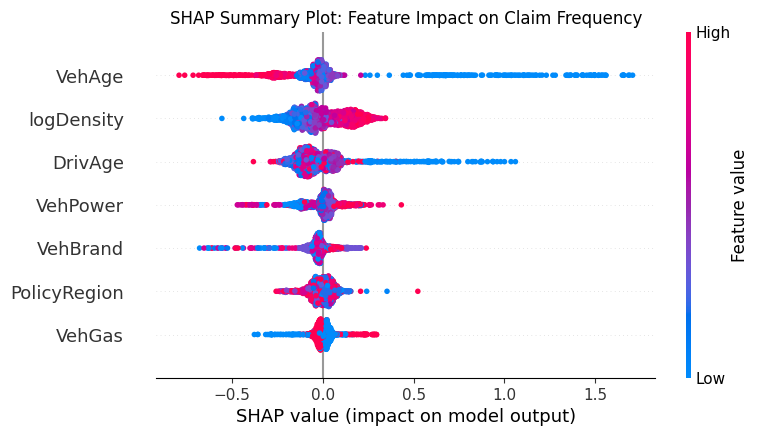

<Figure size 1000x600 with 0 Axes>

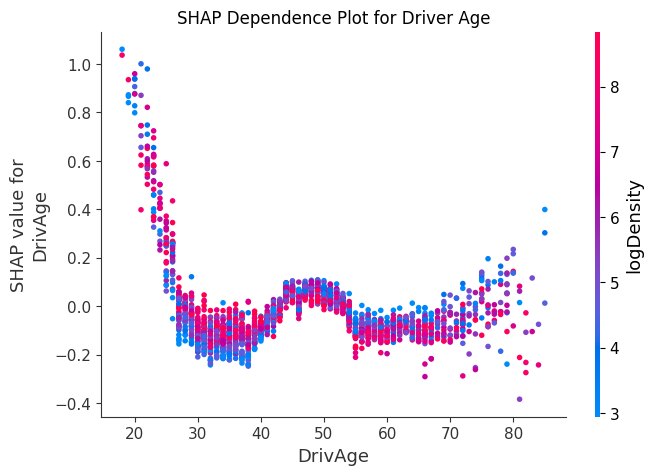

In [4]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize the SHAP Explainer
# We use the TreeExplainer which is optimized for XGBoost
explainer = shap.TreeExplainer(fit_xgb)

# 2. Calculate SHAP values for the test set
# To speed up the process for the tutorial, we take a representative sample
X_test_sample = X_test_xgb.sample(2000, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# 3. Summary Plot: Global importance and impact
# This plot shows which features are most important and how they affect the prediction
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, plot_type="dot", show=False)
plt.title("SHAP Summary Plot: Feature Impact on Claim Frequency")
plt.show()

# 4. Dependence Plot: Focus on Driver Age
# This shows how SHAP values change with DrivAge, highlighting potential interactions
plt.figure(figsize=(10, 6))
shap.dependence_plot("DrivAge", shap_values, X_test_sample, interaction_index="auto", show=False)
plt.title("SHAP Dependence Plot for Driver Age")
plt.show()

In [5]:
import os
import matplotlib.pyplot as plt

# Define and create output directory
output_dir = "../reports/figures"
os.makedirs(output_dir, exist_ok=True)

# 1. Save the Actuarial Risk Profile (DrivAge)
plot_frequency_profile(train, 'DrivAge')
plt.savefig(f"{output_dir}/risk_profile_drivage.png", bbox_inches='tight', dpi=300)
plt.close() # Silence the output

# 2. Save SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, plot_type="dot", show=False)
plt.title("SHAP Summary Plot: Feature Impact on Claim Frequency")
plt.savefig(f"{output_dir}/shap_summary.png", bbox_inches='tight', dpi=300)
plt.close() # Silence the output

# 3. Save SHAP Dependence Plot
plt.figure(figsize=(10, 6))
shap.dependence_plot("DrivAge", shap_values, X_test_sample, interaction_index="auto", show=False)
plt.title("SHAP Dependence Plot for Driver Age")
plt.savefig(f"{output_dir}/shap_dependence_drivage.png", bbox_inches='tight', dpi=300)
plt.close() # Silence the output

print(f"Success! All figures saved in {output_dir}. Notebook output kept clean.")

Success! All figures saved in ../reports/figures. Notebook output kept clean.


<Figure size 1000x600 with 0 Axes>